## Part1: Simulating SIR with Fixed Parameters

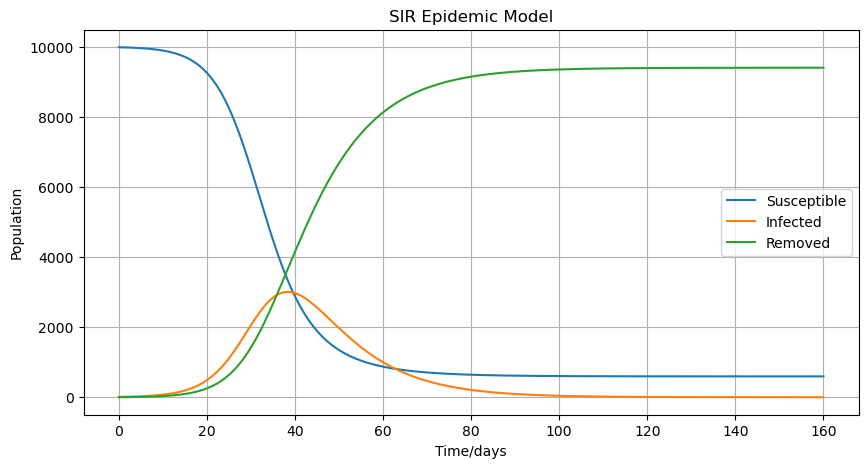

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

N = 10000
I0, R0 = 10, 0
S0 = N-I0-R0

#parameter
beta = 0.3 #infection rate
gamma = 0.1 #recover rate

#SIR ODE
def deriv(y,t,N,beta,gamma):
    S,I,R = y
    dsdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
    return dsdt,dIdt,dRdt

y0 = S0,I0,R0
t = np.linspace(0,160,160)

ret = odeint(deriv,y0,t,args=(N,beta,gamma))
S, I, R = ret.T

plt.figure(figsize = (10,5))
plt.plot(t,S,label='Susceptible')
plt.plot(t,I,label='Infected')
plt.plot(t,R,label='Removed')
plt.xlabel('Time/days')
plt.ylabel('Population')
plt.legend()
plt.title('SIR Epidemic Model')
plt.grid()
plt.show()

## Part2: Fitting SIR to Real COVID-19 Data (Wuhan)

In [9]:
import pandas as pd

df = pd.read_csv("covid_19_clean_complete.csv")
df_hubei = df[df["Province/State"] == "Hubei"].copy()
df_hubei["Date"] = pd.to_datetime(df_hubei["Date"])
df_hubei = df_hubei.sort_values("Date")

confirmed = df_hubei["Confirmed"].values
recovered = df_hubei["Recovered"].values
deaths = df_hubei["Deaths"].values
dates = df_hubei["Date"].values

print("Confirmed cases:", confirmed[:5])
print("Dates:", dates[:5])


Confirmed cases: [ 444  444  549  761 1058]
Dates: ['2020-01-22T00:00:00.000000000' '2020-01-23T00:00:00.000000000'
 '2020-01-24T00:00:00.000000000' '2020-01-25T00:00:00.000000000'
 '2020-01-26T00:00:00.000000000']


In [10]:
N = 11000000
I_data = confirmed - recovered - deaths
R_data = recovered + deaths
S_data = N - I_data - R_data
t = np.arange(len(I_data))

In [11]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import numpy as np

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def solve_SIR(t, beta, gamma):
    y0 = S_data[0], I_data[0], R_data[0]
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    return ret[:, 1]

popt, _ = curve_fit(solve_SIR, t, I_data, p0=[0.4, 0.1])
beta_fit, gamma_fit = popt
print(f"beta = {beta_fit:.4f}, gamma = {gamma_fit:.4f}, R0 = {beta_fit/gamma_fit:.2f}")

beta = 2.1109, gamma = 1.8995, R0 = 1.11


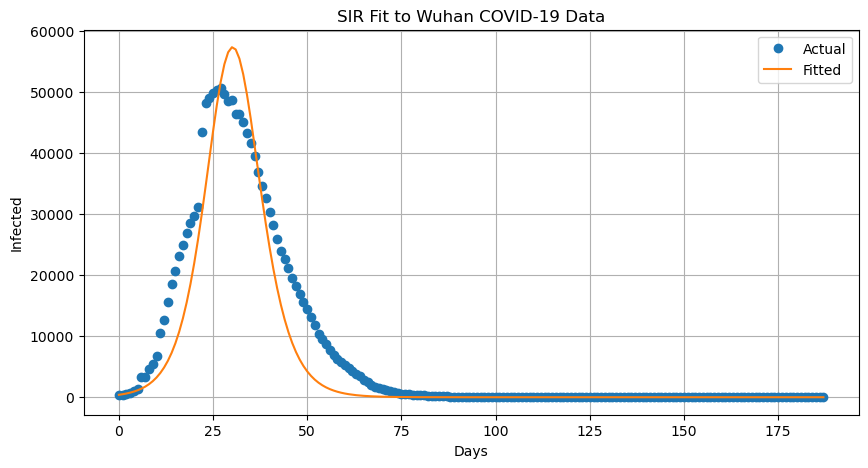

In [14]:
import matplotlib.pyplot as plt

I_fit = solve_SIR(t, beta_fit, gamma_fit)

plt.figure(figsize=(10, 5))
plt.plot(t, I_data, 'o', label='Actual')
plt.plot(t, I_fit, '-', label='Fitted')
plt.legend()
plt.grid()
plt.title("SIR Fit to Wuhan COVID-19 Data")
plt.xlabel("Days")
plt.ylabel("Infected")
plt.show()

## Part3: Insurance Premium Estimation based on SIR

In [15]:
S, I, R = odeint(deriv, (S_data[0], I_data[0], R_data[0]), t, args=(N, beta_fit, gamma_fit)).T

X1 = 3000     # Payout for infection
X2 = 10000    # Payout for death
p = 0.01      # Probability of death given infection

# Compute infection and death probabilities from SIR solution
P_infected = (S_data[0] - S[-1]) / N           
P_death = p * P_infected                      

# Compute the expected pure premium (no loading or discounting)
pure_premium = X1 * P_infected + X2 * P_death

print(f"P(infected) ≈ {P_infected:.4%}")
print(f"P(death) ≈ {P_death:.4%}")
print(f"Estimated pure premium: ¥{pure_premium:.2f}")


P(infected) ≈ 19.3484%
P(death) ≈ 0.1935%
Estimated pure premium: ¥599.80


## Part4a: Sensitivity Analysis – Effect of Fatality Rate on Premium

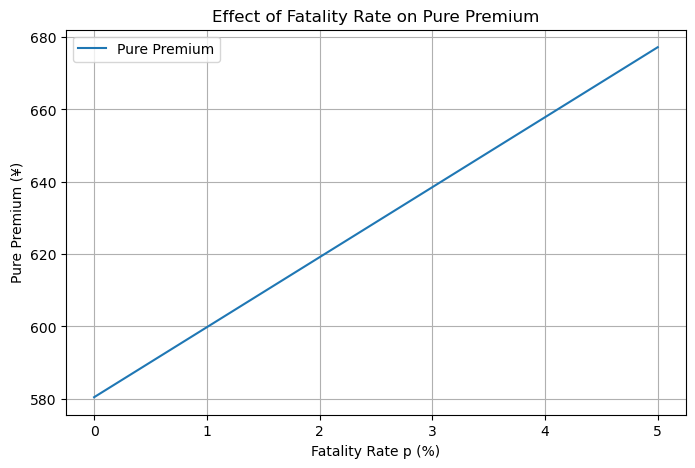

In [16]:
import numpy as np
import matplotlib.pyplot as plt

P_infected = (S_data[0] - S[-1]) / N

X1 = 3000   
X2 = 10000 

p_range = np.linspace(0, 0.05, 100)

premium_values = P_infected * (X1 + X2 * p_range)

plt.figure(figsize=(8, 5))
plt.plot(p_range * 100, premium_values, label='Pure Premium')
plt.xlabel("Fatality Rate p (%)")
plt.ylabel("Pure Premium (¥)")
plt.title("Effect of Fatality Rate on Pure Premium")
plt.grid(True)
plt.legend()
plt.show()


## Part4b: Sensitivity – Pure Premium vs Payout Amounts (X₁ and X₂)

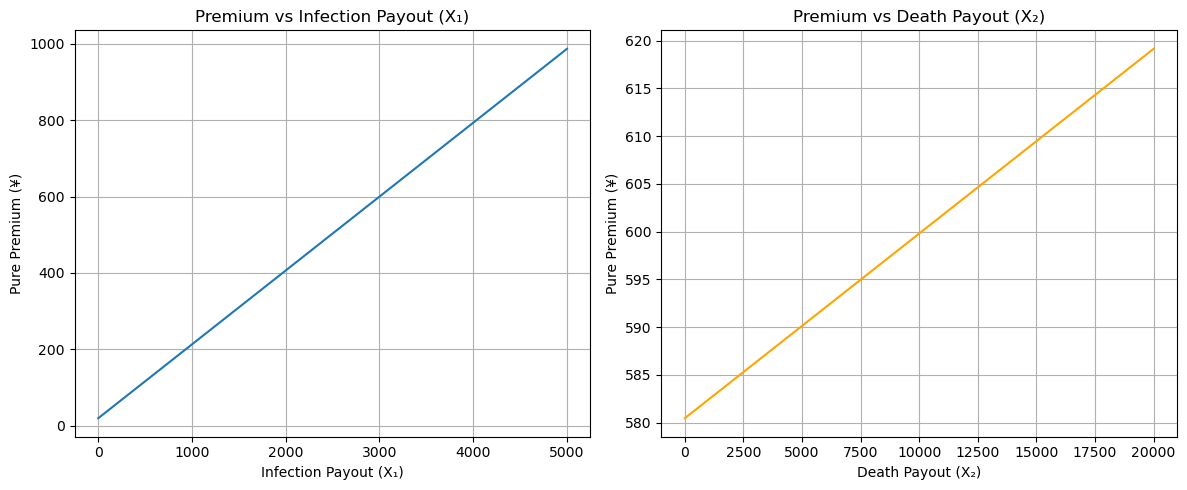

In [17]:
P_infected = (S_data[0] - S[-1]) / N
p = 0.01

X1_range = np.linspace(0, 5000, 100)  
X2_range = np.linspace(0, 20000, 100)

X2_fixed = 10000
premium_vs_X1 = P_infected * (X1_range + X2_fixed * p)

X1_fixed = 3000
premium_vs_X2 = P_infected * (X1_fixed + X2_range * p)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(X1_range, premium_vs_X1)
plt.xlabel("Infection Payout (X₁)")
plt.ylabel("Pure Premium (¥)")
plt.title("Premium vs Infection Payout (X₁)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(X2_range, premium_vs_X2, color='orange')
plt.xlabel("Death Payout (X₂)")
plt.ylabel("Pure Premium (¥)")
plt.title("Premium vs Death Payout (X₂)")
plt.grid(True)

plt.tight_layout()
plt.show()


## Part5: Dynamic Reserve Curve – Future Liabilities Over Time

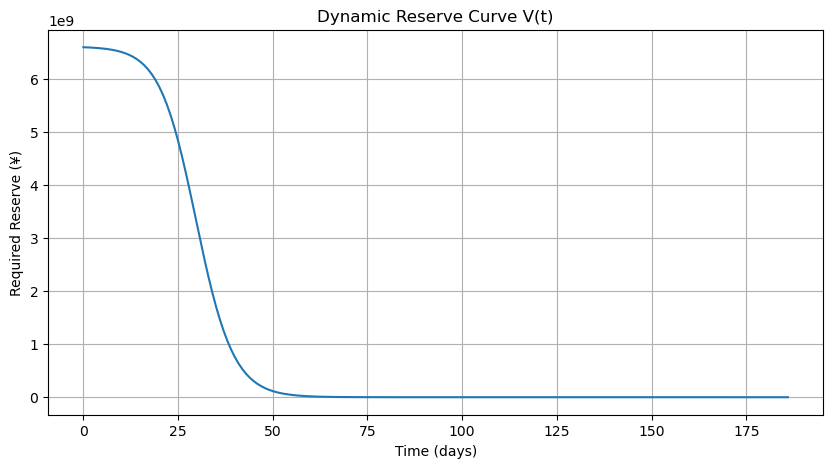

In [18]:
X1 = 3000     # Infection payout
X2 = 10000    # Death payout
p = 0.01      # Fatality rate

S_all = S
delta_I = S_all[:-1] - S_all[1:]
expected_payout_per_infection = X1 + p * X2

V_t = []

for t in range(len(delta_I)):
    remaining_payout = np.sum(delta_I[t:] * expected_payout_per_infection)
    V_t.append(remaining_payout)

t_days = np.arange(len(V_t))

plt.figure(figsize=(10, 5))
plt.plot(t_days, V_t)
plt.xlabel("Time (days)")
plt.ylabel("Required Reserve (¥)")
plt.title("Dynamic Reserve Curve V(t)")
plt.grid(True)
plt.show()